# Tutorial: Gene Regulatory Networks
In this tutorial, we'll use BRICK to interpret a Gene Regulatory Network after Cell Trajectory Inference.

In [1]:
import sys
import os
os.chdir("/Users/shang/Desktop/华大/") # your working path
sys.path.append("/Users/shang/Desktop/华大/BRICK/")

import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import re


import BRICK
from sklearn.preprocessing import StandardScaler

## Configure your LLM

In [2]:
llm_url = "http://XXX.X.X.X:XXXXX" # your LLM url 
llm_params = {
        "model_name": {
        "service_provider": "azure",
        "tpm": 110000,
        "rpm": 660,
        "max_tokens": 32768 * 4,
        "token_per_transaction": 8191,
        "area": "美国中南部",
        "params": {
            "openai_api_base": "", # can be other model api
                    "openai_api_type": "azure",
                    "openai_api_version": "2023-07-01-preview",
                    "openai_api_key": "", # your api key
                    "model_name": "gpt-4-32k",
                    "deployment_name": "depl-gpt4-32k",
                    "temperature": 0.7, 
                    "max_tokens": 5000,
                    "request_timeout": 3000,
                    "max_retries": 5,
                    "openai_proxy": "",
                    "tiktoken_model_name": "gpt-4"
            },
        }
}

gpt_4o = "http://127.0.0.1:62140"
gpt_4o_params = {
    "gpt-4o": {
    "service_provider": "azure",
    "tpm": 110000,
    "rpm": 660,
    "max_tokens": 32768 * 4,
    "token_per_transaction": 8191,
    "area": "美国中南部",
    "llm_params": {
                "openai_api_base": "https://rhx3zc5jd3mps.openai.azure.com",
                "openai_api_type": "azure",
                "openai_api_version": "2023-07-01-preview",
                "model_name": "gpt-4o",
                "deployment_name": "depl-gpt4o",
                "openai_api_key": "7c8bf41e5bf44e3786fd0553415563db",
                "temperature": 0.7, 
                "max_tokens": 4096,
                "request_timeout": 3000,
                "max_retries": 5,
                "streaming": False,
                "openai_proxy": "",
                "tiktoken_model_name": "gpt-3.5-turbo", #gpt-4
                "callbacks": None
            },
        }
}

BRICK.config_llm(gpt_4o, gpt_4o_params)

/Users/shang/Desktop/华大/BRICK/_settings.py:59: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  _llm_instance = AzureChatOpenAI(**llm_params[first_key]["llm_params"])


LLM gpt-4o has been configured and initialized successfully.


/Users/shang/miniconda3/envs/brick/lib/python3.10/site-packages/langchain_community/chat_models/azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://rhx3zc5jd3mps.openai.azure.com to https://rhx3zc5jd3mps.openai.azure.com/openai.
  warnings.warn(
/Users/shang/miniconda3/envs/brick/lib/python3.10/site-packages/langchain_community/chat_models/azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is specified then `openai_api_base` (or alias `base_url`) should not be. Instead use `deployment_name` (or alias `azure_deployment`) and `azure_endpoint`.
  warnings.warn(
/Users/shang/miniconda3/envs/brick/lib/python3.10/site-packages/langchain_community/chat_models/azure_openai.py:189: UserWarning: As of openai>=1.0.0, if `openai_api_base` (or alias `base_url`) is specified it is expected to 

## Configure your Knowledge Graph

In [3]:
url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

## Now we start to analyse GRN
We'll use pyScenic to calculate GRN and find specific TF-regulon in cell development of interest.

In [80]:
adata = sc.read_h5ad("/Users/shang/Desktop/华大/trajectory/data.nosync/adata_cluster_0.h5ad")
adata

AnnData object with n_obs × n_vars = 19869 × 2000
    obs: 'organism_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'author_experimental_id', 'author_day', 'author_somite_count', 'author_major_cell_cluster', 'author_cell_type', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes', 'leiden', 'paga_cluster'
    var: 'gene_short_name', 'chr', 'start', 'end', 'strand', 'gene_type', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'author_day_colors', 'author_somite_count_colors', 'cell_type_colors', 'cell_type_sizes', 'citati

## Specific pre-process steps
You can use different pre-process steps

/Users/shang/miniconda3/envs/brick/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


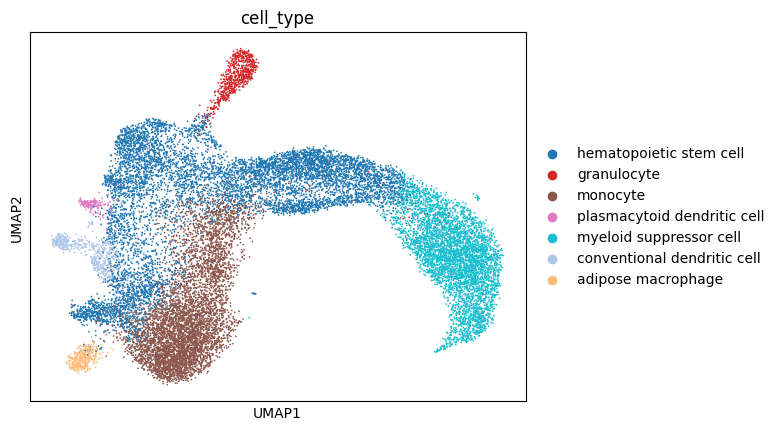

In [6]:
sc.pp.neighbors(adata)
sc.pp.pca(adata)
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell_type'] == 'hematopoietic stem cell')[0]
sc.tl.dpt(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color="cell_type")

## Get gene expression matrix

In [8]:
expression_matrix = pd.DataFrame(
    adata.X.toarray(),  
    index=adata.obs_names,  
    columns=adata.var_names  
)
#expression_matrix.to_csv("./expression_matrix.csv")

# Get verified TF-regulon
We'll use pyScenic to get TF-regulon. 

An example code of pyScenic to get all necessary files: 
1) calculate GRN
``` shell
pyscenic grn ./expression_matrix.csv ./filtered_TF_ensembl.txt -o adjacencies.tsv --num_workers 4
```

2) filter module
``` shell
pyscenic ctx adjacencies.tsv hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather --annotations_fname motifs-v9-nr.hgnc-m0.001-o0.0.tbl -o modules.tsv --num_workers 4
```

3) calculate AUCell score
``` shell
pyscenic aucell ./expression_matrix_converted.csv ./modules.tsv -o g_auc_mtx.csv --num_workers 4
```
\
After running pyScenic, we can use modules.tsv file and get_verified_tf() function to get verified tf-regulon

## Path of interest
We are interested in the developmental path between 'Conventional Dendritic Cell' and 'Adipose Macrophage', and we want to identify which TF-regulons regulate this path.

### Visualization of the correlation distribution of marker genes for two target cell types.

This plot visualizes the correlation distribution of marker genes associated with the two target cell types, conventional dendritic cell and adipose macrophage, along a pseudotime trajectory.

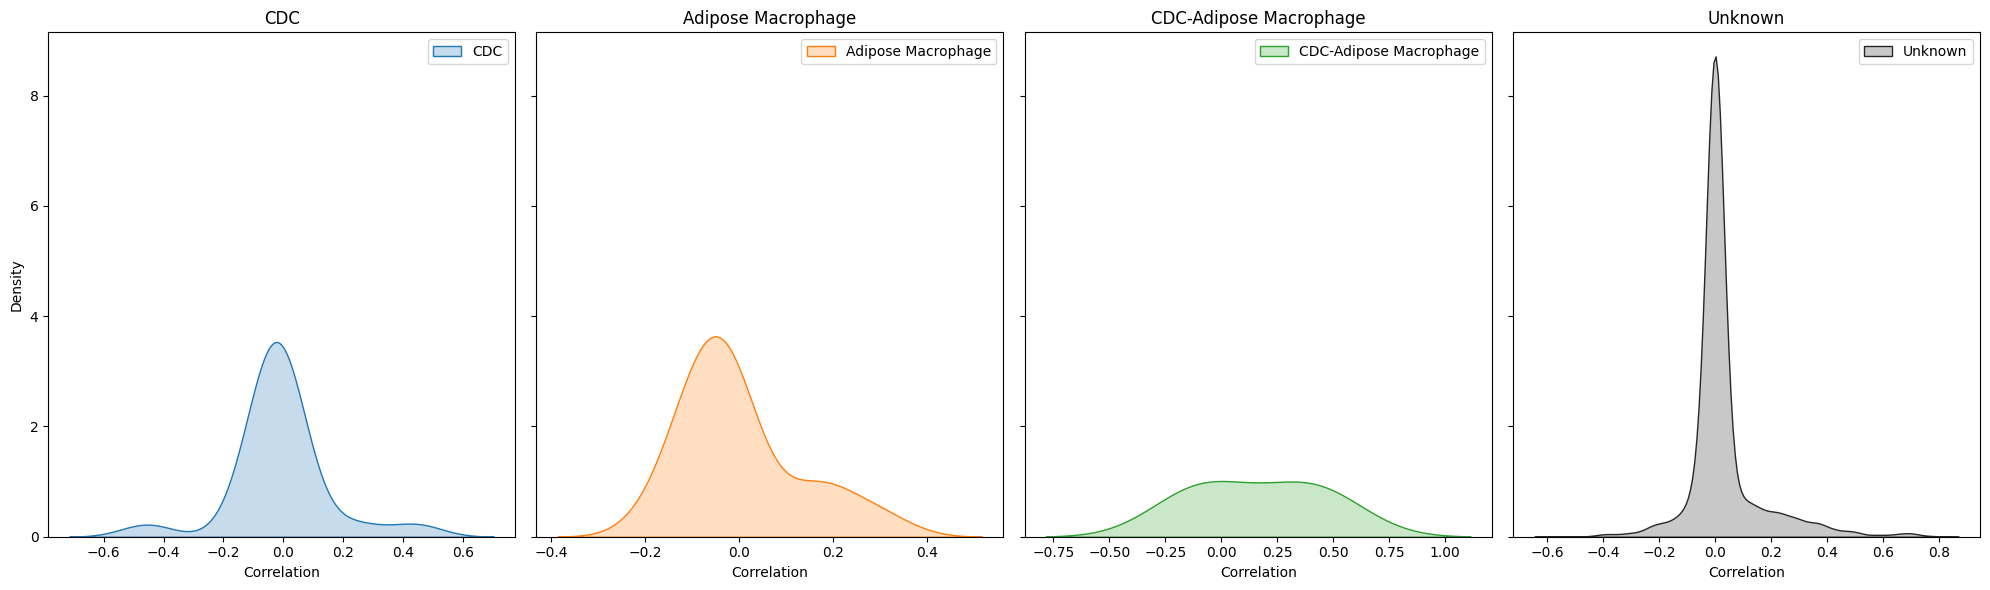

In [24]:
target_cells = ["conventional dendritic cell","adipose macrophage"]
all_markers = BRICK.qr.query_neighbor(target_cells,relation="marker_of",source_entity_type="Cell",target_entity_type="Gene")

kgr = all_markers.groupby("path.0.name")["path.2.name"].apply(list).to_dict()
gd = adata.var["feature_name"].to_dict()

gene_correlations = {}
for id,gene in gd.items():
    expression = adata[:, id].X.toarray().flatten()
    pseudotime = adata.obs["dpt_pseudotime"]
    correlation, pval = spearmanr(expression, pseudotime)
    gene_correlations[gene] = (correlation, pval)
    
cor_df = pd.DataFrame.from_dict(gene_correlations, orient="index", columns=["correlation", "pval"])
cor_df = cor_df.sort_values("correlation", ascending=False)

gene_to_cell = defaultdict(list)
for cell, genes in kgr.items():
    for gene in genes:
        gene_to_cell[gene].append(cell)

cor_df["cell_type"] = cor_df.index.map(
    lambda gene: "-".join(gene_to_cell[gene]) if gene in gene_to_cell else "Unknown"
)

def classify_cell_type(cell_type, target_cells):
    if cell_type == "Unknown" or pd.isna(cell_type):
        return "Unknown"
    
    cells = set(cell_type.split("-"))
    target_in_cells = cells.intersection(target_cells)
    
    if len(target_in_cells) == 2:
        return "CDC-Adipose Macrophage" 
    elif "conventional dendritic cell" in target_in_cells:
        return "CDC" 
    elif "adipose macrophage" in target_in_cells:
        return "Adipose Macrophage"
    else:
        return "Unknown" 

cor_df["cell_group"] = cor_df["cell_type"].apply(lambda x: classify_cell_type(x, target_cells))
cell_groups = ["CDC", "Adipose Macrophage", "CDC-Adipose Macrophage", "Unknown"]

plot_data = cor_df[cor_df["cell_group"].isin(cell_groups)]
plot_data = plot_data[["cell_group", "pval", "correlation"]]

colors = {
    "CDC": "#1f77b4",  
    "Adipose Macrophage": "#ff7f0e",  
    "CDC-Adipose Macrophage": "#2ca02c",
    "Unknown": "#27272790",
}

fig, axes = plt.subplots(1, len(cell_groups), figsize=(20, 6), sharey=True)

for ax, group in zip(axes, cell_groups):
    sns.kdeplot(
        data=plot_data[plot_data["cell_group"] == group]["correlation"],
        ax=ax,
        fill=True,
        label=group,
        color=colors.get(group, "red"), 
    )
    ax.set_title(f"{group}")
    ax.set_xlabel("Correlation")
    ax.set_ylabel("Density")
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [26]:
filtered_data = plot_data[plot_data["cell_group"] != "Unknown"]
filtered_data = filtered_data[["cell_group", "pval", "correlation"]]

gene_list = filtered_data.index.to_list()

print(gene_list[:5])

['Itgam', 'Ly75', 'Lyz2', 'Cd33', 'Plbd1']


Then we can use these specific marker genes to find all verified TF

In [122]:
module_file = "/Users/shang/Desktop/华大/trajectory/modules.tsv"
gene_list = adata.var["feature_name"].tolist() # use gene name instead of gene id
top_tf = BRICK.pp.get_verified_tf(module_file,gene_list)

## Visualization
Visualize cluster heatmap of expression of regulon

/Users/shang/miniconda3/envs/brick/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/var/folders/qx/3nkwgrqn7p5gqg57g_t2flrr0000gn/T/ipykernel_64462/3122314517.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


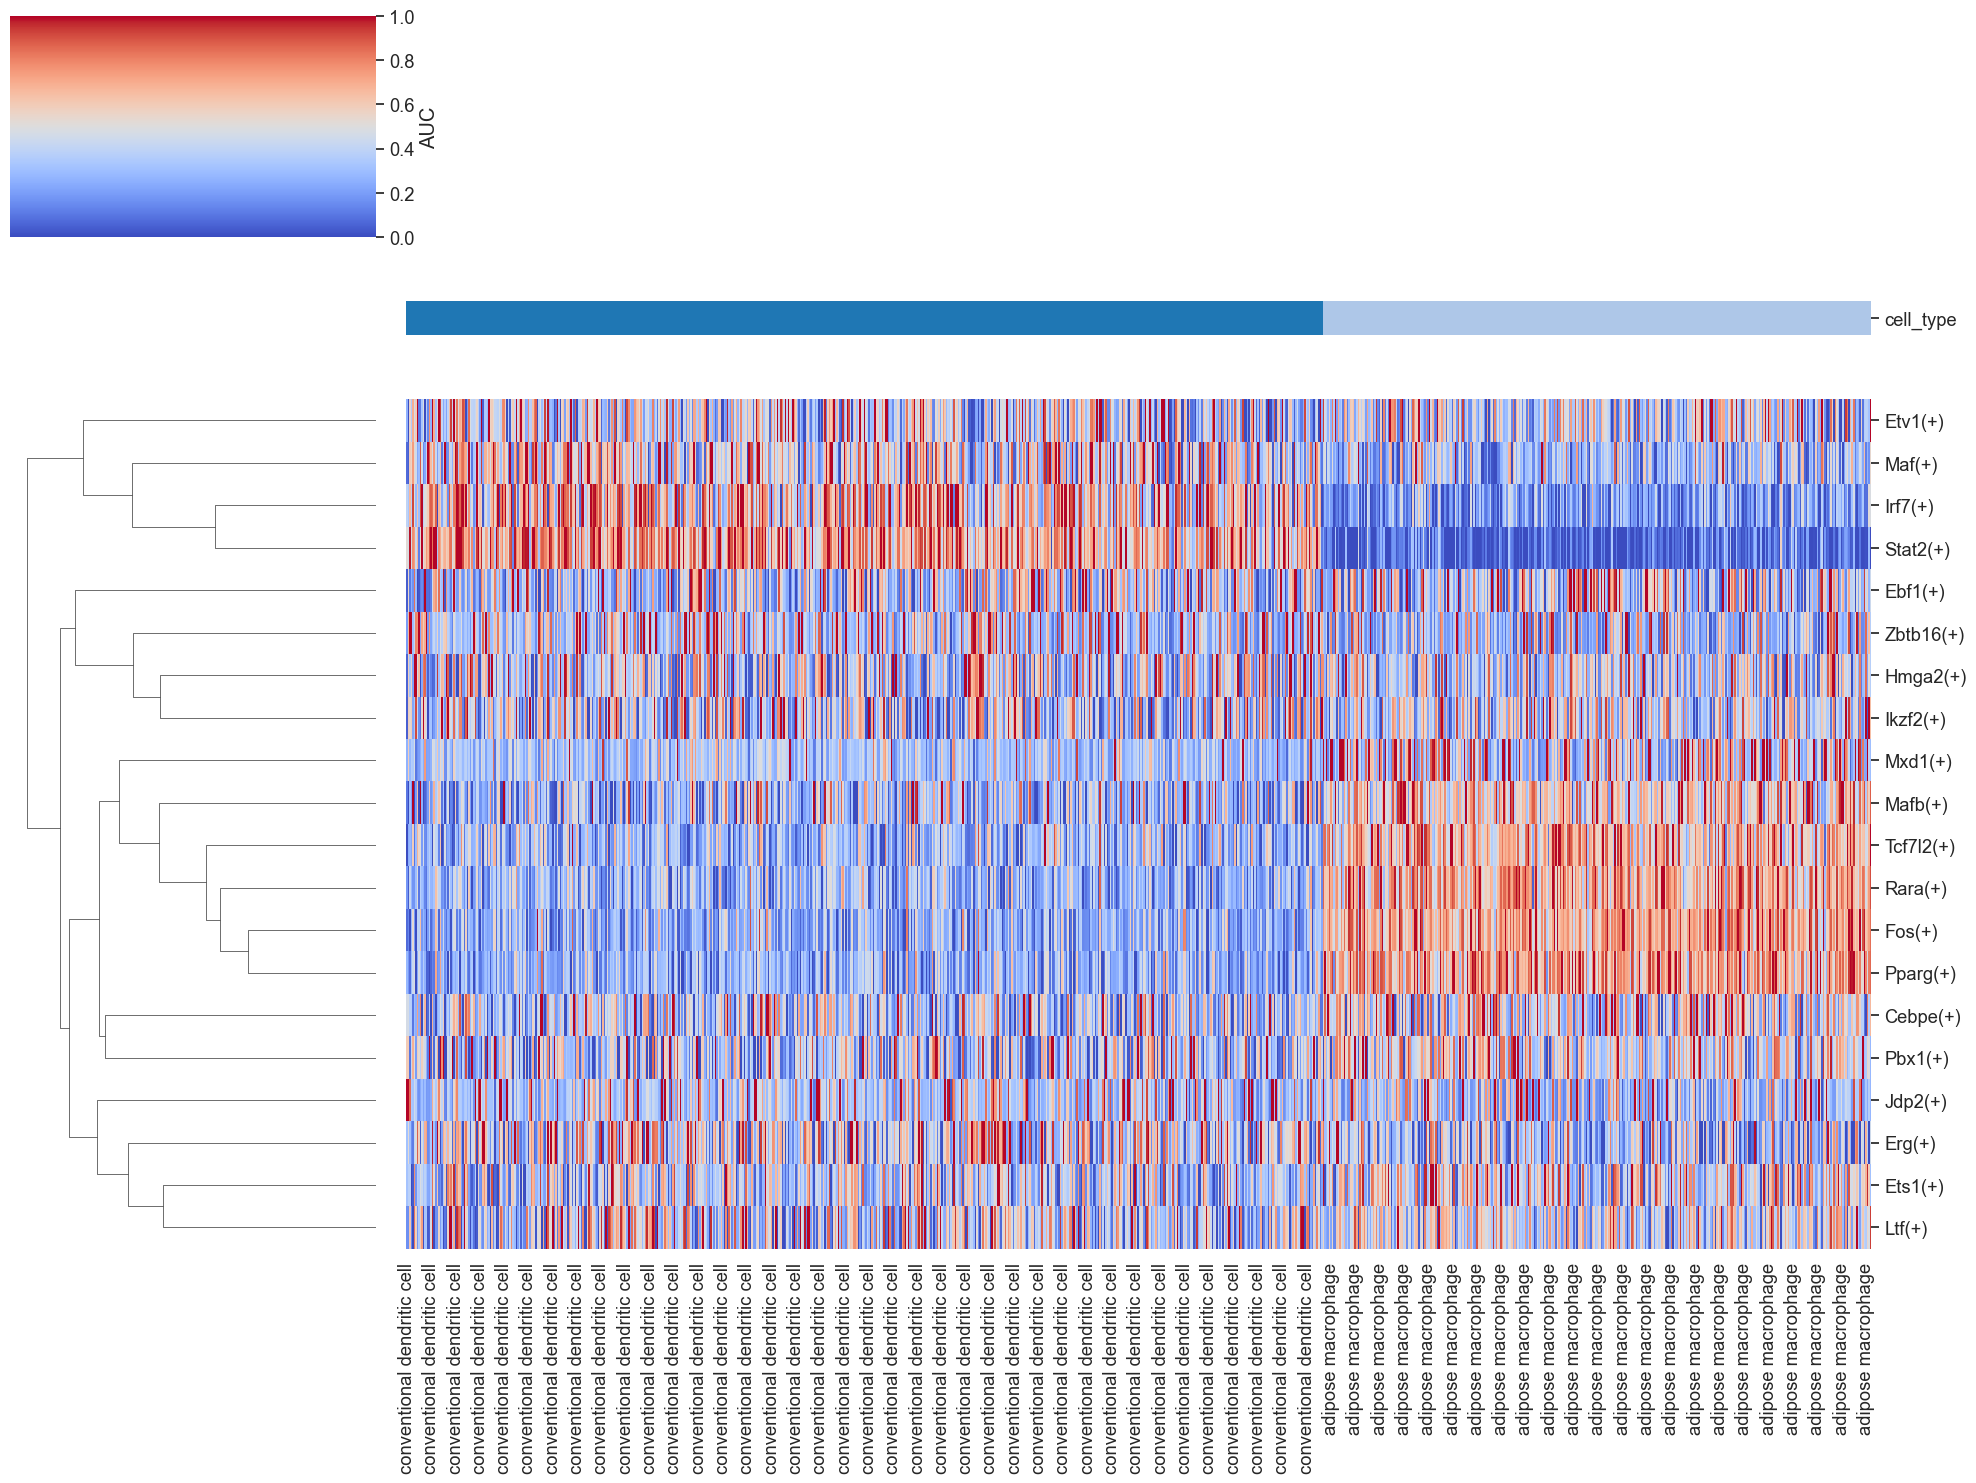

In [7]:
aucell_matrix_sorted = pd.read_csv("/Users/shang/Desktop/华大/trajectory/data.nosync/auc_mtx.csv", index_col=0)

aucell_matrix_sorted["cell_type"] = adata.obs["cell_type"]

aucell_matrix_sorted = aucell_matrix_sorted[aucell_matrix_sorted["cell_type"].isin(["conventional dendritic cell", "adipose macrophage"])]

aucell_matrix_sorted = aucell_matrix_sorted.dropna(subset=["cell_type"]) 

aucell_matrix_sorted = aucell_matrix_sorted.sort_values("cell_type")

cell_types = aucell_matrix_sorted["cell_type"]

scaler = StandardScaler()
aucell_matrix_scaled = pd.DataFrame(
    scaler.fit_transform(aucell_matrix_sorted.iloc[:, 1:-1]), 
    index=aucell_matrix_sorted.index, 
    columns=aucell_matrix_sorted.columns[1:-1]
)

unique_cell_types = cell_types.unique()
palette = sns.color_palette("tab20", len(unique_cell_types))
cell_type_colors = dict(zip(unique_cell_types, palette))

cell_types = cell_types.astype(str)
col_colors = cell_types.map(cell_type_colors)

sns.set(font_scale=1.2) 

aucell_matrix_scaled.index = cell_types.values
col_colors.index = cell_types.values
g = sns.clustermap(
    aucell_matrix_scaled.transpose(),
    cbar_kws={'label': 'AUC'},
    cmap="coolwarm",  
    figsize=(20, 15),  
    row_cluster=True,  
    col_cluster=False,  
    annot=False,
    standard_scale=1,
    col_colors=col_colors
)

plt.tight_layout()
plt.show()

Visualize specific TF in target cells

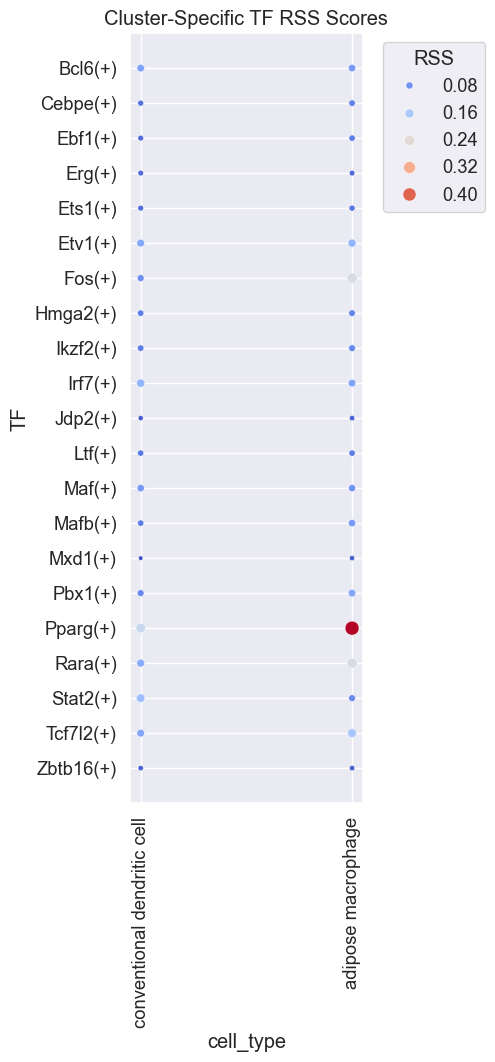

In [8]:
aucell_matrix_grouped = aucell_matrix_sorted.groupby("cell_type").mean()

aucell_matrix_grouped = aucell_matrix_grouped.dropna()

rss_melted = aucell_matrix_grouped.reset_index().melt(id_vars="cell_type", var_name="TF", value_name="RSS")

rss_melted
plt.figure(figsize=(3, 10))
sns.scatterplot(
    data=rss_melted,
    x="cell_type", y="TF", size="RSS", hue="RSS",
    palette="coolwarm", sizes=(10, 100)
)
plt.title("Cluster-Specific TF RSS Scores")
plt.xticks(rotation=90)

plt.legend(title='RSS', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.show()



Visualize rank of each TF in target cell type

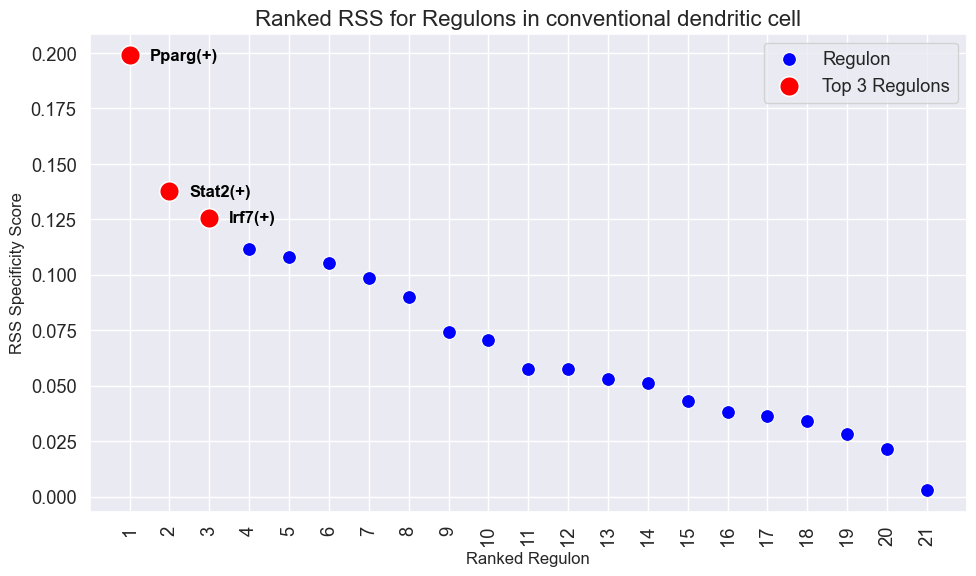

In [9]:
cell_type_of_interest = 'conventional dendritic cell'  

rss_matrix = rss_melted.pivot(index='cell_type', columns='TF', values='RSS')

rss_cell_type = rss_matrix.loc[cell_type_of_interest]

rss_sorted = rss_cell_type.sort_values(ascending=False)

top_3_regulons = rss_sorted.head(3)

ranked_data = pd.DataFrame({
    'Rank': range(1, len(rss_sorted) + 1),
    'Regulon': rss_sorted.index,
    'RSS': rss_sorted.values
})

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=ranked_data, 
    x='Rank',  
    y='RSS', 
    color='blue', 
    label='Regulon', 
    s=100  
)

sns.scatterplot(
    data=ranked_data[ranked_data['Regulon'].isin(top_3_regulons.index)], 
    x='Rank', 
    y='RSS', 
    color='red', 
    label='Top 3 Regulons',
    s=200  
)

for rank, (regulon, rss_value) in enumerate(top_3_regulons.items(), start=1):
    plt.text(
        rank + 0.5, rss_value,  
        regulon, 
        horizontalalignment='left',  
        verticalalignment='center',
        fontsize=12, color='black', fontweight='bold'
    )


plt.title(f'Ranked RSS for Regulons in {cell_type_of_interest}', fontsize=16)
plt.xlabel('Ranked Regulon', fontsize=12)
plt.ylabel('RSS Specificity Score', fontsize=12)

plt.xticks(ticks=ranked_data['Rank'], labels=ranked_data['Rank'], rotation=90)

plt.legend()

plt.tight_layout()
plt.show()


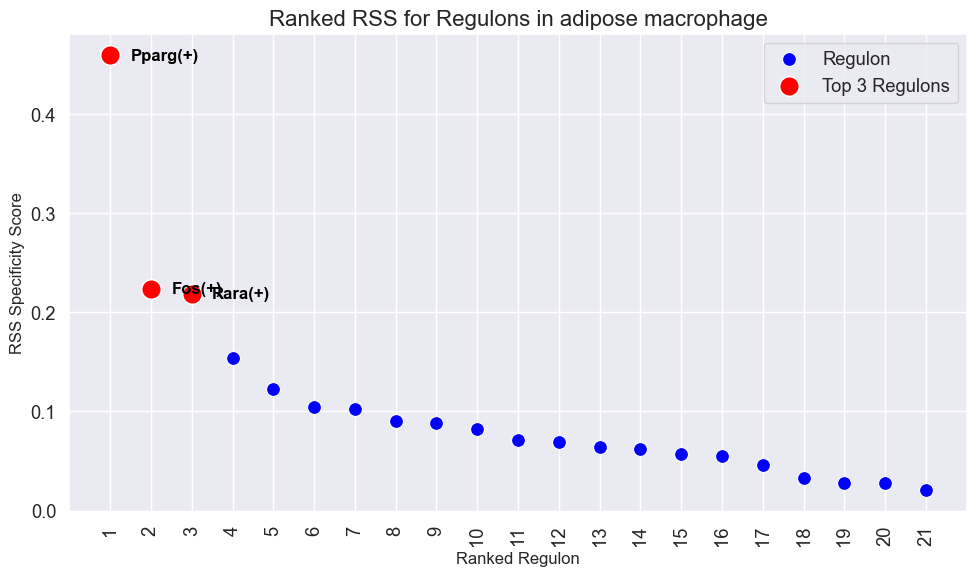

In [10]:
cell_type_of_interest = 'adipose macrophage'  

rss_matrix = rss_melted.pivot(index='cell_type', columns='TF', values='RSS')

rss_cell_type = rss_matrix.loc[cell_type_of_interest]

rss_sorted = rss_cell_type.sort_values(ascending=False)

top_3_regulons = rss_sorted.head(3)

ranked_data = pd.DataFrame({
    'Rank': range(1, len(rss_sorted) + 1), 
    'Regulon': rss_sorted.index,
    'RSS': rss_sorted.values
})

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=ranked_data, 
    x='Rank',  
    y='RSS', 
    color='blue',  
    label='Regulon', 
    s=100 
)

sns.scatterplot(
    data=ranked_data[ranked_data['Regulon'].isin(top_3_regulons.index)], 
    x='Rank', 
    y='RSS', 
    color='red', 
    label='Top 3 Regulons',
    s=200  
)

for rank, (regulon, rss_value) in enumerate(top_3_regulons.items(), start=1):
    plt.text(
        rank + 0.5, rss_value,  
        regulon, 
        horizontalalignment='left',  
        verticalalignment='center',
        fontsize=12, color='black', fontweight='bold'
    )

plt.title(f'Ranked RSS for Regulons in {cell_type_of_interest}', fontsize=16)
plt.xlabel('Ranked Regulon', fontsize=12)
plt.ylabel('RSS Specificity Score', fontsize=12)

plt.xticks(ticks=ranked_data['Rank'], labels=ranked_data['Rank'], rotation=90)

plt.legend()

plt.tight_layout()
plt.show()


Visualize the Relationship Between Transcription Factor Expression Levels and RSS Scores in target cells

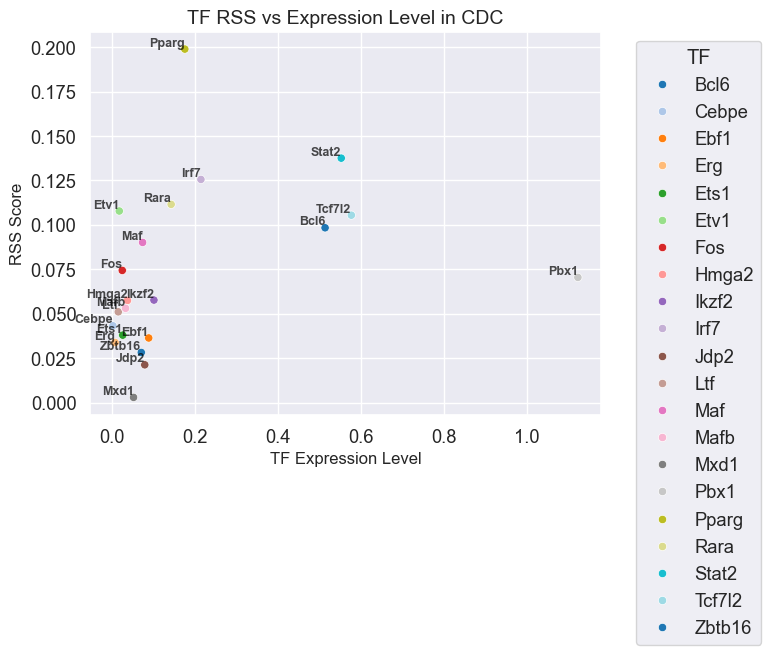

In [72]:
tf_expression = pd.DataFrame(adata.X.toarray(), index=adata.obs["cell_type"], columns=adata.var["feature_name"])

cdc_rss = rss_melted[rss_melted['cell_type'] == 'conventional dendritic cell'].copy()

cdc_rss["TF_cleaned"] = cdc_rss["TF"].str.replace(r"\(\+\)", "", regex=True)

cdc_expression = tf_expression.loc['conventional dendritic cell', cdc_rss["TF_cleaned"]]

cdc_expression_mean = cdc_expression.mean(axis=0)

combined_df = pd.DataFrame({
    'TF': cdc_rss["TF_cleaned"],
    'RSS': cdc_rss["RSS"],
    'Expression': cdc_expression_mean[cdc_rss["TF_cleaned"]].values
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_df, x="Expression", y="RSS", hue="TF", palette="tab20")

for i, row in combined_df.iterrows():
    plt.text(
        row['Expression'], 
        row['RSS'], 
        row['TF'], 
        fontsize=9, 
        ha='right',  
        va='bottom',  
        alpha=0.7,  
        color='black',  
        fontweight='bold' 
    )

plt.title("TF RSS vs Expression Level in CDC", fontsize=14)
plt.xlabel("TF Expression Level", fontsize=12)
plt.ylabel("RSS Score", fontsize=12)

plt.legend(title='TF', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


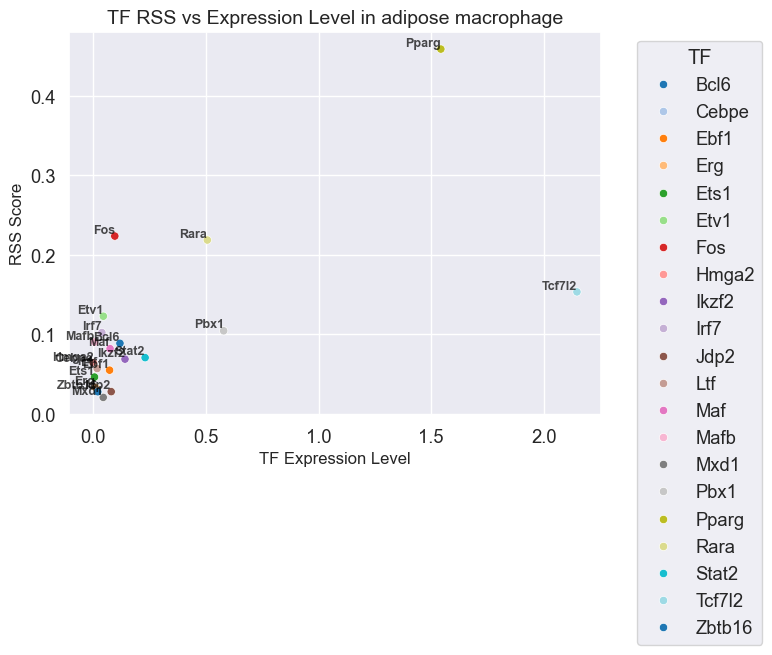

In [71]:
tf_expression = pd.DataFrame(adata.X.toarray(), index=adata.obs["cell_type"], columns=adata.var["feature_name"])

am_rss = rss_melted[rss_melted['cell_type'] == 'adipose macrophage'].copy()

am_rss["TF_cleaned"] = am_rss["TF"].str.replace(r"\(\+\)", "", regex=True)

am_expression = tf_expression.loc['adipose macrophage', am_rss["TF_cleaned"]]

am_expression_mean = am_expression.mean(axis=0)

combined_df = pd.DataFrame({
    'TF': am_rss["TF_cleaned"],
    'RSS': am_rss["RSS"],
    'Expression': am_expression_mean[am_rss["TF_cleaned"]].values
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_df, x="Expression", y="RSS", hue="TF", palette="tab20")

for i, row in combined_df.iterrows():
    plt.text(
        row['Expression'], 
        row['RSS'], 
        row['TF'], 
        fontsize=9, 
        ha='right',  
        va='bottom',  
        alpha=0.7,  
        color='black',  
        fontweight='bold' 
    )

plt.title("TF RSS vs Expression Level in adipose macrophage", fontsize=14)
plt.xlabel("TF Expression Level", fontsize=12)
plt.ylabel("RSS Score", fontsize=12)

plt.legend(title='TF', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Visualize TF expression in UMAP using three approaches: (1) all TFs across all cell types, (2) a specific TF across all cell types, and (3) a specific TF across selected cell types.

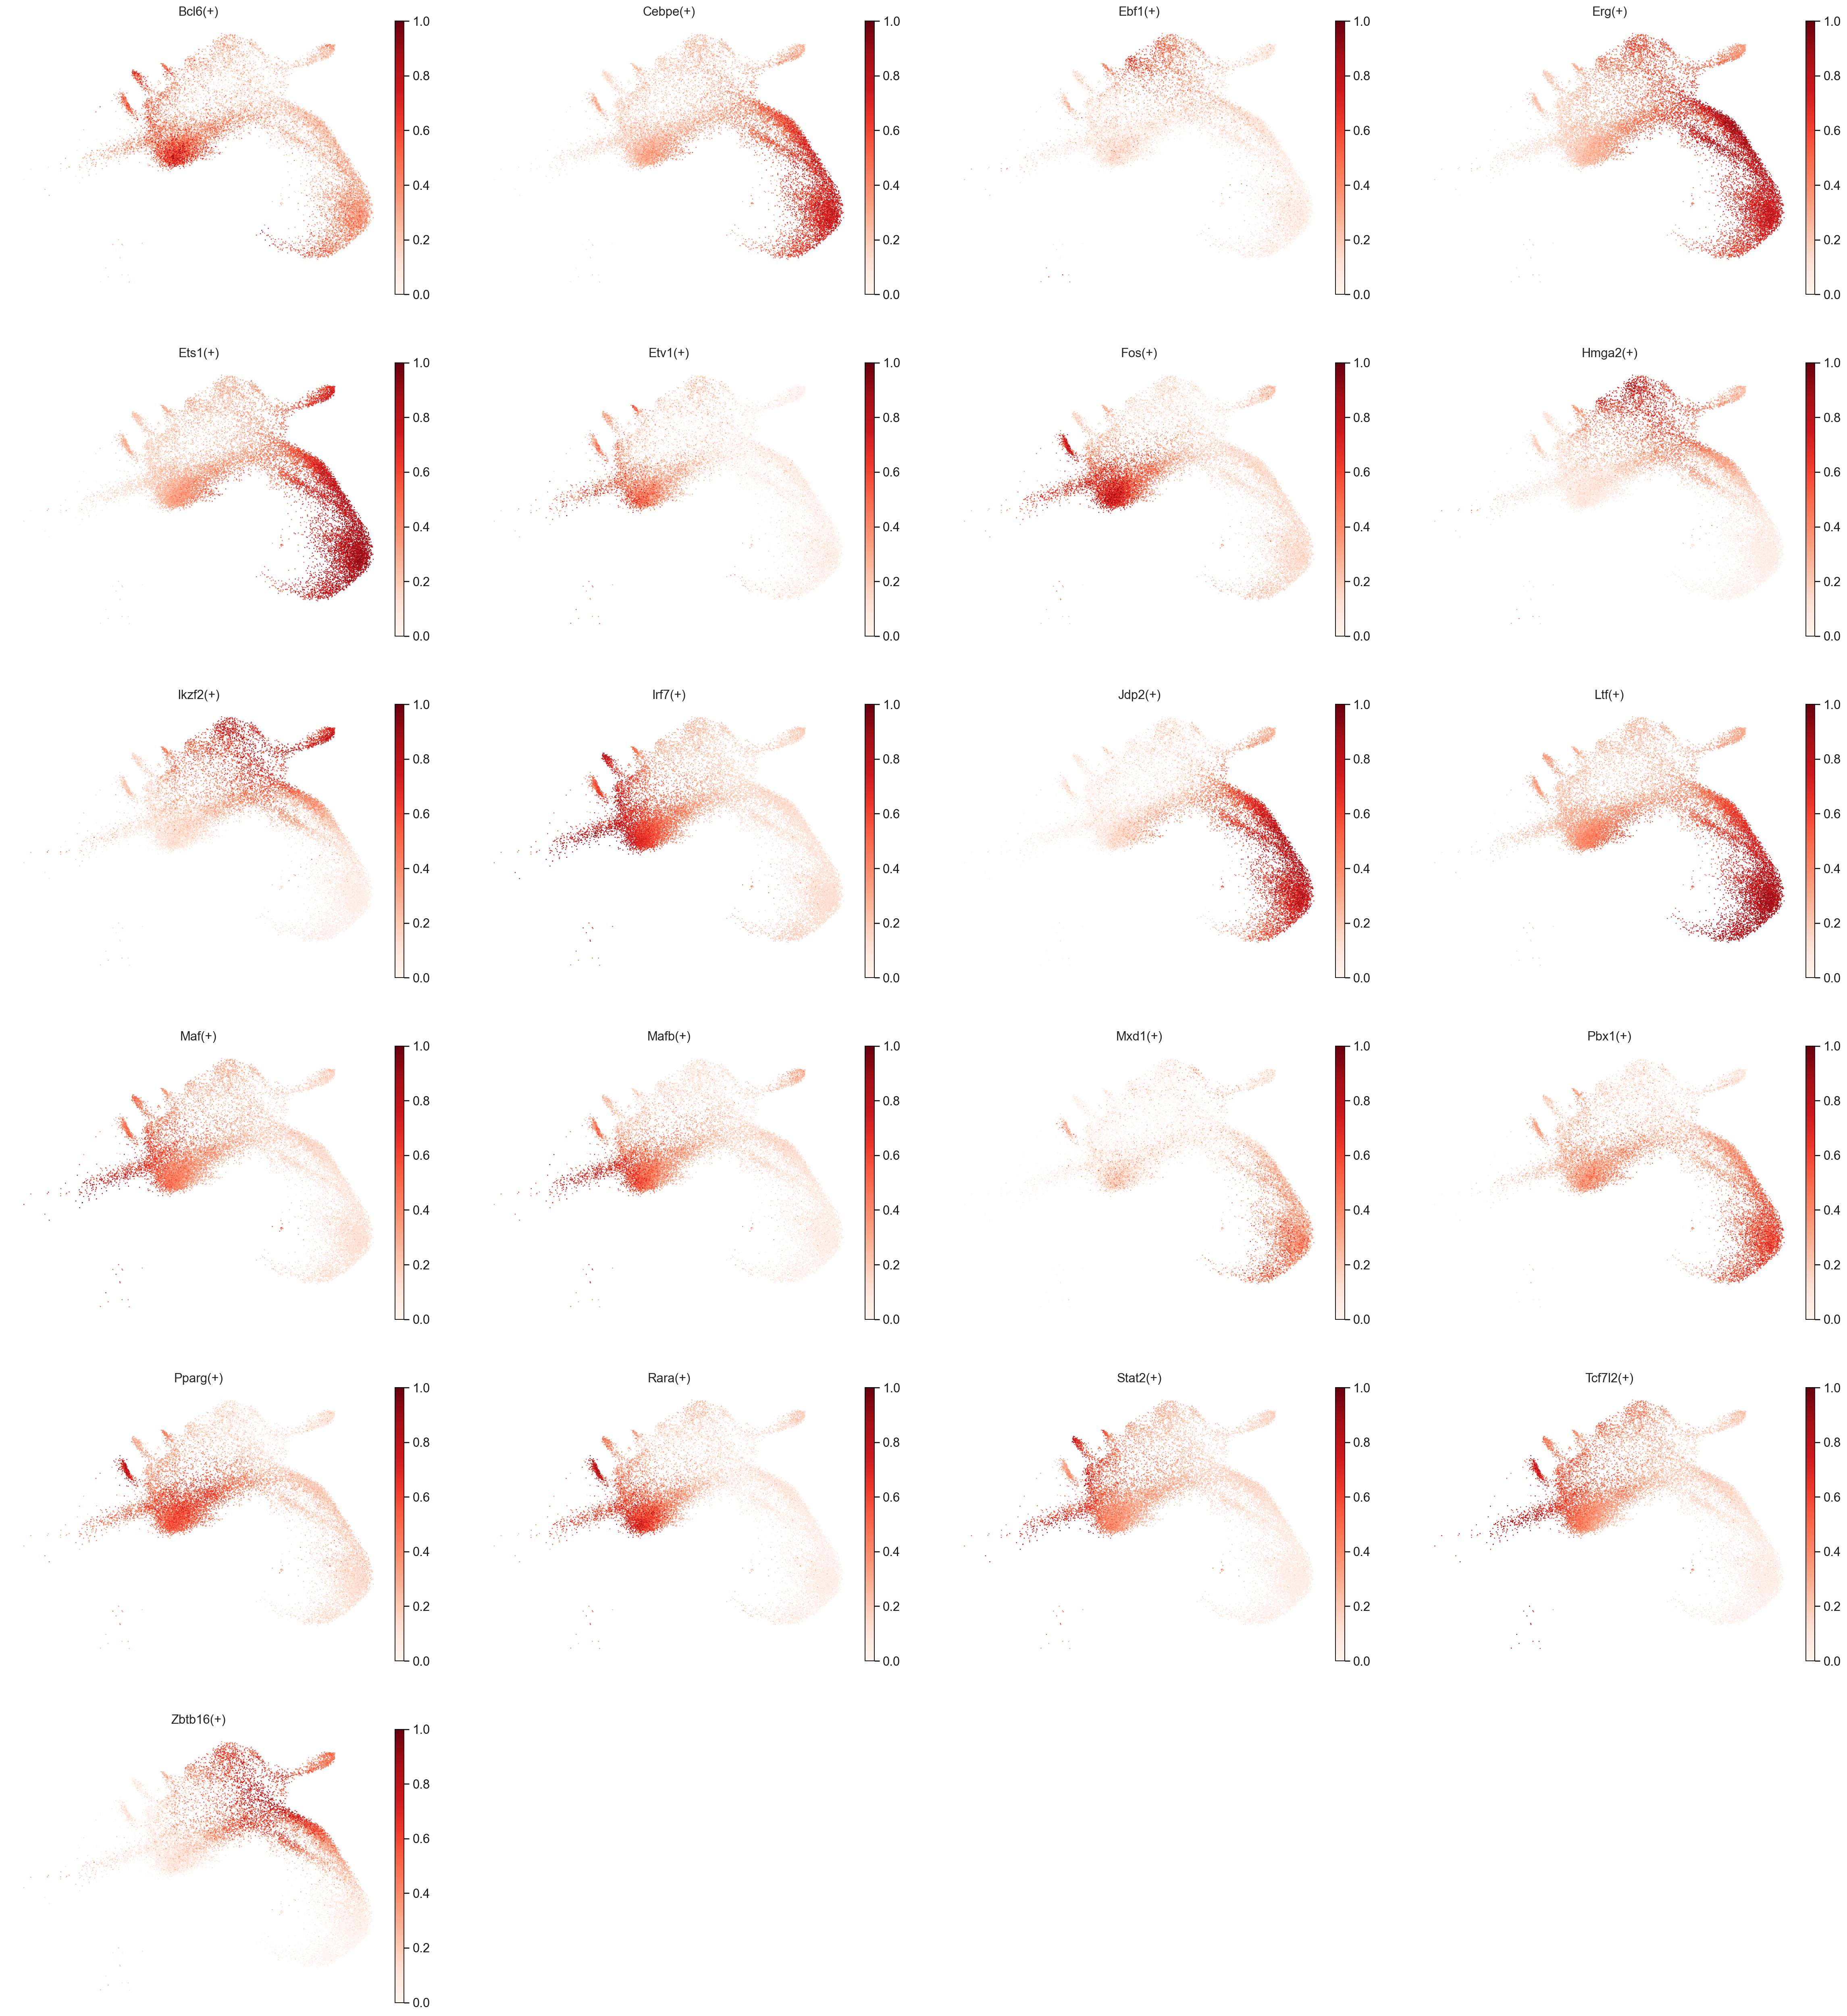

In [96]:
# (1)
b = adata.copy()
auc_matrix = pd.read_csv('/Users/shang/Desktop/华大/trajectory/data.nosync/auc_mtx.csv', index_col=0)

target_cell_types = ['conventional dendritic cell', 'adipose macrophage']

auc_matrix = auc_matrix.astype('float64')

if auc_matrix.isnull().values.any():
    auc_matrix.fillna(0, inplace=True)

b.obs = pd.concat([b.obs, auc_matrix], axis=1)

tfname = auc_matrix.columns

for tf in tfname:
    b.obs[tf] = (b.obs[tf] - b.obs[tf].min()) / (b.obs[tf].max() - b.obs[tf].min())

cmap = sns.color_palette("Reds", as_cmap=True)

sc.set_figure_params(figsize=(8, 6))
sc.pl.umap(b, color=tfname, cmap=cmap, frameon=False, show=False)

plt.show()


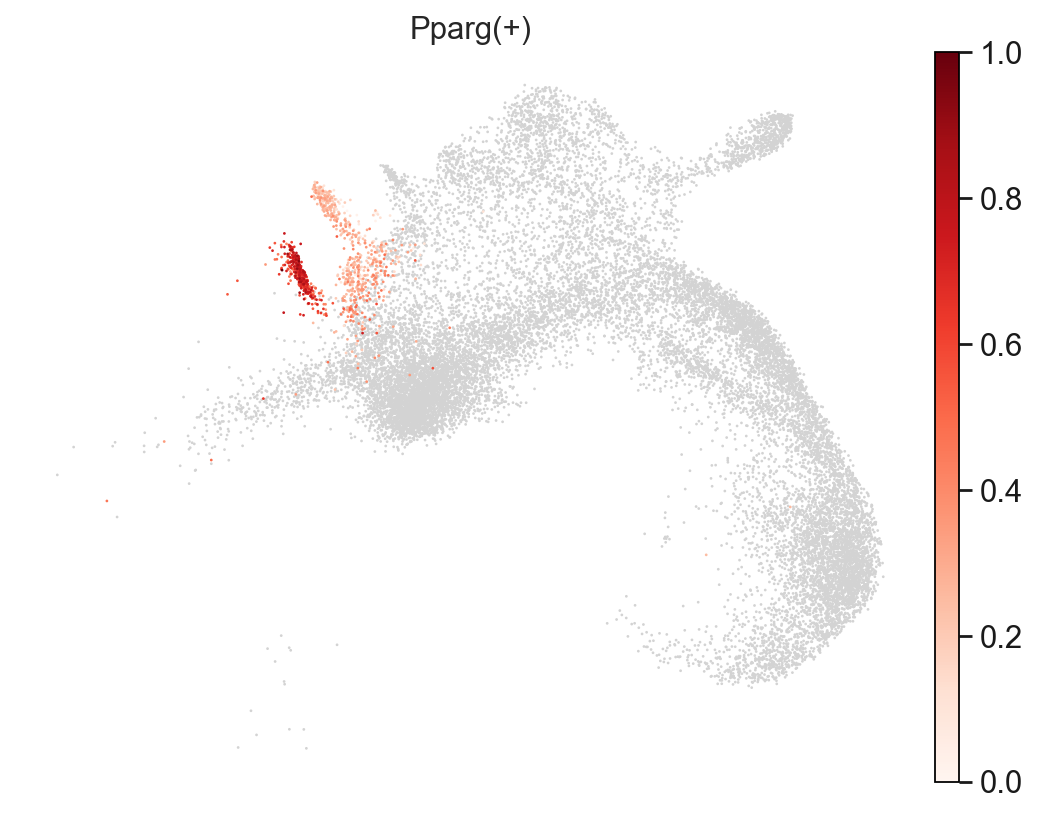

In [97]:
# (2)
b = adata.copy()
target_cell_types = ['conventional dendritic cell', 'adipose macrophage']
#t = b[b.obs['cell_type'].isin(target_cell_types)]

auc_matrix = aucell_matrix_sorted

if auc_matrix.isnull().values.any():
    auc_matrix.fillna(0, inplace=True)

b.obs = pd.concat([b.obs, auc_matrix], axis=1)

tfname = "Pparg(+)"

b.obs[tfname] = (b.obs[tfname] - b.obs[tfname].min()) / (b.obs[tfname].max() - b.obs[tfname].min())

cmap = sns.color_palette("Reds", as_cmap=True) 

sc.set_figure_params(figsize=(8, 6))
sc.pl.umap(b, color=tfname, cmap=cmap, frameon=False, show=False)

plt.show()

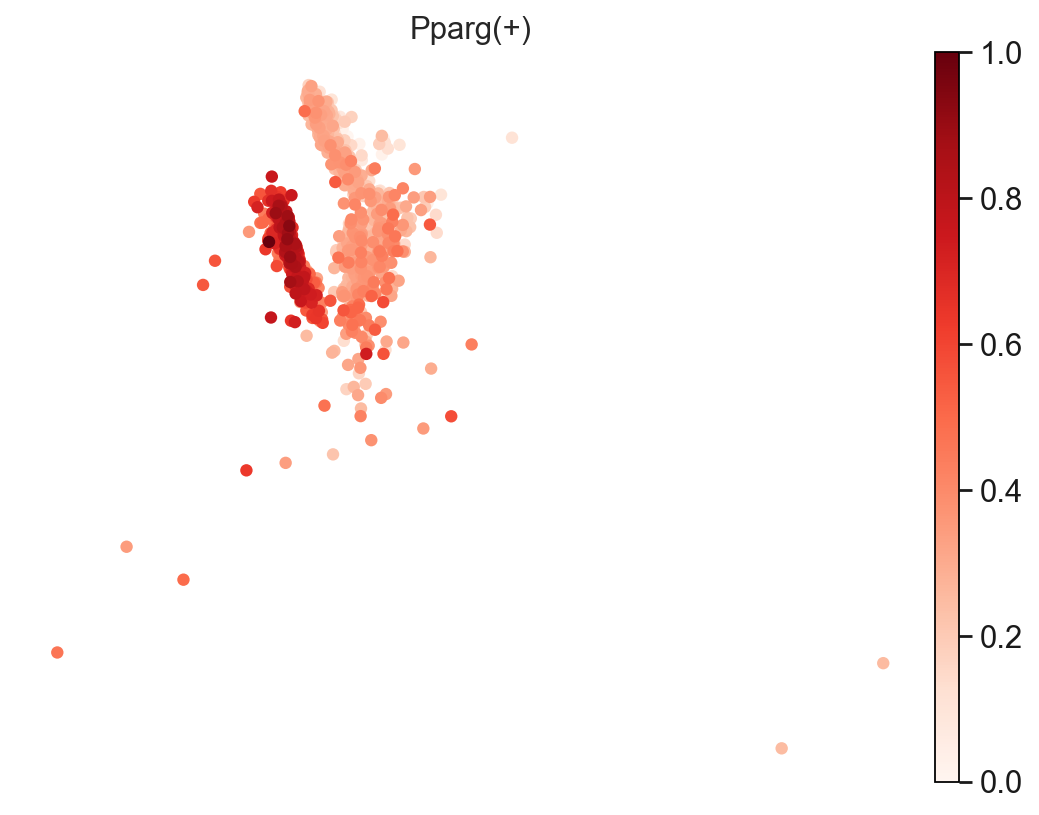

In [94]:
# (3)
b = adata.copy()
target_cell_types = ['conventional dendritic cell', 'adipose macrophage']
b = b[b.obs['cell_type'].isin(target_cell_types)]

auc_matrix = aucell_matrix_sorted

if auc_matrix.isnull().values.any():
    auc_matrix.fillna(0, inplace=True)

b.obs = pd.concat([b.obs, auc_matrix], axis=1)

tfname = "Pparg(+)"

b.obs[tfname] = (b.obs[tfname] - b.obs[tfname].min()) / (b.obs[tfname].max() - b.obs[tfname].min())

cmap = sns.color_palette("Reds", as_cmap=True) 

sc.set_figure_params(figsize=(8, 6))
sc.pl.umap(b, color=tfname, cmap=cmap, frameon=False, show=False)

plt.show()

Visualize of each verified/unverified TF 

In [106]:
#cypher_grn = ("MATCH (n:Gene|Protein)-[r:regulated|activate|interact_with]->(m:Gene|Protein) WHERE n.name = $TF AND m.name IN $gene_list AND NOT 'SCENIC' IN r.info_source RETURN n,r,m")

cypher_grn = ("MATCH (n:Gene)-[r:regulated|activate|interact_with]->(m:Gene|Protein) WHERE n.name IN $TF AND m.name IN $gene_list RETURN n,r,m")

tf_interest = rss_sorted.index[0]
TF = re.findall(r"^[^(]+", tf_interest)

params = {"TF": TF, "gene_list": list(gene_list)}

result = BRICK.qr.query_cypher(cypher_grn,parameters=params)

verified_gene = result["m.name"].tolist()

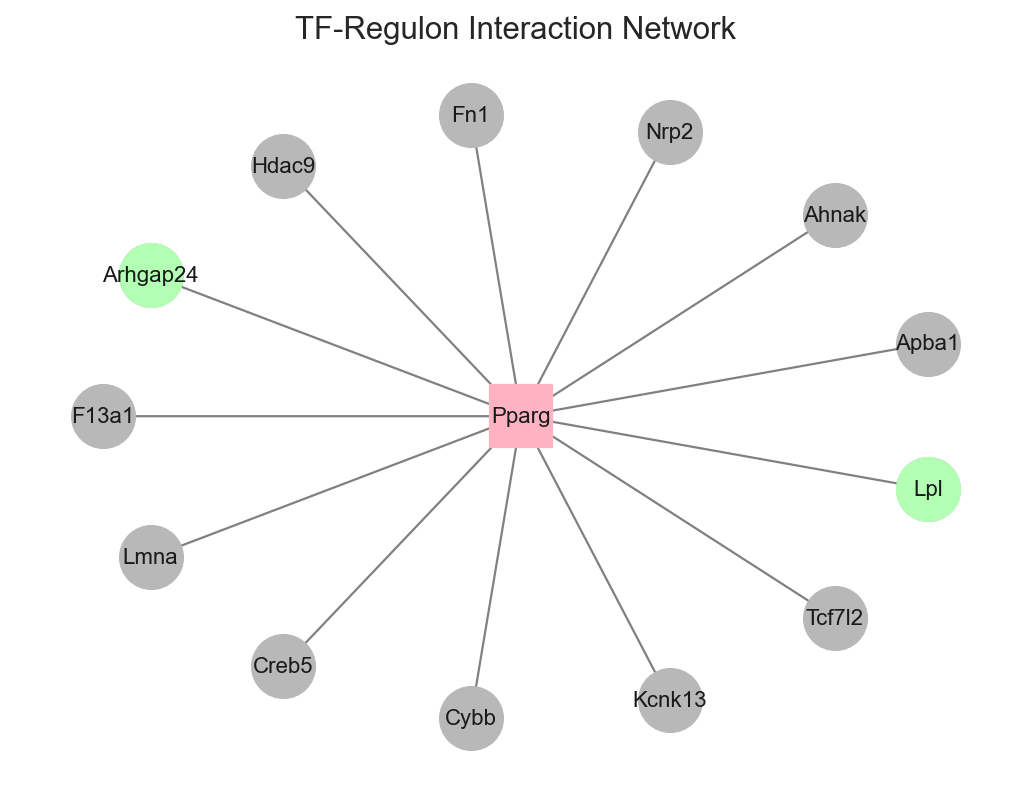

In [126]:
BRICK.pl.visualise_tf_regulon(TF,top_tf,verified_gene)

# Generate Interpretation

You can use your configured LLM to generate interpretations for your data. We have provided a default question and prompt for each sub-task, but feel free to customize or create your own as needed.
### Interpret Gene Regulatory Networks
Use a customized Cypher query to retrieve information from the Knowledge Graph.

For example, retrieve details about the transcription factor (TF) "Pparg" and its associated regulon.

In [3]:
regulon = top_tf.loc[TF,"Regulon"].explode().tolist()
tf_list = list(set(result["n.name"]))

result = BRICK.inp.analyse_grn(tf_list,verified_gene,regulon,sub_task="analyse how this TF-regulon regulate the develop path from conventional dendritic cell to adipose macrophage")
print("Generated Answer:", result)

Now generating answer ... 

Generated Answer: In the context of your mission to analyze how the transcription factor (TF) Pparg regulates the developmental pathway from conventional dendritic cells to adipose macrophages, it is essential to consider the regulatory relationships between Pparg and the genes in its regulon. Let's delve into the details based on the provided information.

### Transcription Factor: Pparg

Pparg (Peroxisome proliferator-activated receptor gamma) is a key transcription factor involved in various biological processes, particularly in adipogenesis, inflammation, and immune response regulation. Its role in regulating gene expression is crucial for the differentiation and function of adipose tissues and immune cells.

### Verified Genes

The genes listed in the `#verified_gene#` list have been experimentally validated to be regulated by Pparg. These genes have been calculated by the SCENIC method and proven through experimental studies, confirming their regulator

**现在生成答案...**

**生成的答案：**

在您研究转录因子 (TF) Pparg 如何调控从传统树突状细胞向脂肪组织巨噬细胞的发育途径的背景下，理解 Pparg 及其调控基因之间的关系至关重要。我们将基于提供的信息深入探讨相关细节。

### **转录因子：Pparg**

Pparg（过氧化物酶体增殖物激活受体 γ）是一个关键的转录因子，参与多种生物过程，尤其是在脂肪生成、炎症以及免疫反应调节中发挥重要作用。它对基因表达的调控对于脂肪组织和免疫细胞的分化与功能至关重要。

### **已验证基因**

列在 `#verified_gene#` 列表中的基因已通过实验验证，表明它们受 Pparg 调控。这些基因经过 SCENIC 方法的计算，并通过实验研究证明了它们与 Pparg 的调控关系。以下是一些重要的基因：

1. **Klrb1b:** 参与自然杀伤细胞功能和免疫反应。  
2. **Fabp4:** 在脂肪酸结合和代谢中发挥作用，对脂肪细胞功能至关重要。  
3. **Lpl (脂蛋白脂肪酶):** 对脂质代谢和能量平衡至关重要。  
4. **Tlr8 (样受体 8):** 参与先天免疫反应。  
5. **Cyp3a25:** 属于细胞色素 P450 家族，参与药物代谢。

这些基因涵盖了多种功能，突显了 Pparg 对脂质代谢、免疫反应和细胞分化等生物途径的广泛调控影响。

### **潜在调控基因**

列在 `#regulon#` 列表中的基因，如 `Apba1`、`Ahnak`、`Nrp2` 和 `Fn1`，虽然尚未经过实验验证，但已通过 SCENIC 方法识别为可能受 Pparg 调控。这表明它们可能属于 Pparg 的调控网络，在传统树突状细胞向脂肪组织巨噬细胞的发育途径中发挥重要作用。

### **功能意义**

理解 Pparg 与其调控基因的关系对于解析脂肪组织巨噬细胞从传统树突状细胞发育过程中的转录控制机制至关重要。Pparg 对涉及脂质代谢（例如 Fabp4、Lpl）和免疫反应（例如 Tlr8、Klrb1b）的基因的影响，强调了它在协调该发育过程中代谢和免疫功能方面的关键作用。

### **实验验证**

尽管 SCENIC 方法提供了潜在调控关系的重要见解，但仍需通过实验验证 Pparg 对调控网络中基因的调节。这将确保对转录网络及其功能意义有更全面的理解。实验方法包括染色质免疫共沉淀 (ChIP)、报告基因检测以及基因敲除/敲低研究等。

### **结论**

转录因子 Pparg 在传统树突状细胞向脂肪组织巨噬细胞转变过程中对基因表达的调控中发挥了核心作用。`#verified_gene#` 列表中的基因为理解核心调控机制奠定了坚实基础。然而，仍需对 SCENIC 方法识别出的其他基因进行实验验证。这一全面分析将有助于更深入地理解免疫和代谢细胞分化与功能中的转录调控机制。

In [134]:
regulon = top_tf.loc[TF,"Regulon"].explode().tolist()
tf_list = list(set(result["n.name"]))

result = BRICK.inp.analyse_grn(tf_list,verified_gene,regulon,sub_task="analyse TF-regulon from conventional dendritic cell develop into adipose macrophage")
print("Generated Answer:", result)

Now generating answer ... 

Generated Answer: In your mission to analyze the gene regulatory network involving the transcription factor (TF) Pparg, which plays a crucial role in the development of conventional dendritic cells transitioning into adipose macrophages, we can derive significant insights by examining the regulatory relationships between Pparg and its target genes.

### Verified Gene Analysis

From the provided list of verified genes, we can see that several genes have already been experimentally validated to be regulated by Pparg. These genes include:

1. **Klrb1b**
2. **Rflnb**
3. **Elovl7**
4. **2010310C07Rik**
5. **Rap1gapos**
6. **1600027J07Rik**
7. **1700034G24Rik**
8. **Gm7616**
9. **Cyp3a25**
10. **Serpina4-ps1**
11. **Sycp2**
12. **Auts2**
13. **Syne2**
14. **Hip1r**
15. **Slc27a4**
16. **Tnfsf13b**
17. **Ets1**
18. **Ces2e**
19. **Arhgap24**
20. **Glis3**
21. **Ccno**
22. **Acot5**
23. **Sema6d**
24. **Duoxa1**
25. **Sgms1**
26. **Rara**
27. **Prom1**
28. **Plcb1**

In [11]:
# Another example, retrieve details about the transcription factor (TF) "Ets1" and its associated regulon.
grn_cypher = "MATCH (n:Gene|Protein)-[r:regulated|activate|interact_with]->(m:Gene|Protein) WHERE n.name = $TF AND m.name IN $gene_list AND NOT 'SCENIC' IN r.info_source RETURN n,r,m"
data = BRICK.qr.query_cypher(grn_cypher, parameters = {"TF":"Ets1","gene_list":['Adpgk', 'Cd300lf', 'Mmp9', 'Chst15', 'Ltf']})

tf_list = []
verified_gene = []
tf_list.append(data["n.name"])
verified_gene.append(data["m.name"])

result = BRICK.inp.analyse_grn(tf_list,verified_gene,regulon,sub_task="analyse TF-regulon from hematopoietic stem cell develop into granulocyte")
print("Generated Answer:", result)

Now generating answer ... 

Generated Answer: The analysis of the transcription factor (TF) Ets1 and its associated regulon in the context of hematopoietic stem cell (HSC) development into granulocytes reveals several key insights. This analysis is crucial for understanding the gene regulatory network (GRN) underpinning this differentiation process.

### Transcription Factor: Ets1
Ets1 is a member of the ETS family of transcription factors, which are known to play significant roles in various biological processes, including cell proliferation, differentiation, and apoptosis. In the context of hematopoiesis, Ets1 is particularly important for the differentiation of HSCs into granulocytes, a type of white blood cell essential for the immune response.

### Verified Gene List
The list of genes that have been experimentally verified to be regulated by Ets1 includes:

- Mmp9 (Matrix metallopeptidase 9)

These genes were identified through the SCENIC (Single-Cell Regulatory Network Inference 